In [1]:
!pip install datasets
!pip install bitsandbytes
!pip install peft
!pip install accelerate
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 4.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 kB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 7.1 MB/s eta 0:00:00


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

In [3]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
dataset = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train")

README.md:   0%|          | 0.00/677 [00:00<?, ?B/s]

(…)-00000-of-00001-e270777bb989ac86.parquet:   0%|          | 0.00/3.45M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

### Trainer with DataCollatorForCompletionOnlyLM

Equivalent to PLW = 0.0

In [5]:
# def formatting_prompts_func(example):
#     output_texts = []
#     for i in range(len(example['instruction'])):
#         text = f"### Question: {example['instruction'][i]}\n### Answer: {example['output'][i]}"
#         output_texts.append(text)
#     return output_texts

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        prompt = f"### Question: {example['instruction'][i]}\n"
        if example["input"][i]:
            prompt += f"### Input: {example['input'][i]}\n"

        prompt += "### Answer:"

        text = prompt + example['output'][i]
    
        output_texts.append(text)
    
    return output_texts

In [550]:
response_template = "### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

trainer = SFTTrainer(
    model,
    train_dataset=dataset,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:149: UserWarning: No `SFTConfig` passed, using `output_dir=tmp_trainer`.
  warnings.warn(f"No `SFTConfig` passed, using `output_dir={output_dir}`.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/20022 [00:00<?, ? examples/s]

In [551]:
dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})

In [552]:
masked1 = trainer.data_collator.torch_call([trainer.train_dataset[0]])
masked1

{'input_ids': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
          2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
          5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
         31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
          1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
             8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
          1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
         12606,   176,  2055,   155,  3226,  1178]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
     

In [553]:
masked1['input_ids'][0]

tensor([    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
         2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
         5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
        31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
         1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
            8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
         1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
        12606,   176,  2055,   155,  3226,  1178])

In [554]:
masked1['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [555]:
masked1['labels'][0]

tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
         1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
            8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
         1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
        12606,   176,  2055,   155,  3226,  1178])

In [556]:
tokenizer.decode([9232,   856,  1640,
         1178,  3256, 50118,  1437,  1437,  1437, 49434, 50118,  1437,  1437,
         1437, 29072,    10,  2167,  8135,     8,  9108,    10,  2167,  4195,
          634,   143, 30412,  5990, 50118,  1437,  1437,  1437, 49434, 50118,
         1437,  1437,  1437,   671,  3023, 12606,   176,  2055,   155,  3226,
         1178])

'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x'

In [557]:
dataset[0]['output']

'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x'

In [558]:
model.device

device(type='cuda', index=0)

In [559]:
masked1 = masked1.to(model.device)
masked1

{'input_ids': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
          2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
          5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
         31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
          1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
             8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
          1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
         12606,   176,  2055,   155,  3226,  1178]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]], device='cuda:0'), 'labels': tensor([[ -100,  -100,  -100,  -100,  -100,  -100,

In [560]:
trainer.compute_loss(model, masked1)

tensor(2.3737, device='cuda:0', grad_fn=<NllLossBackward0>)

### Trainer with PLW = 1 (default)

In [561]:
# def formatting_prompts_func(example):
#     output_texts = []
#     for i in range(len(example['instruction'])):
#         text = f"### Question: {example['instruction'][i]}\n ### Answer: {example['output'][i]}"
#         output_texts.append(text)
#     return output_texts

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        prompt = f"### Question: {example['instruction'][i]}\n"
        if example["input"][i]:
            prompt += f"### Input: {example['input'][i]}\n"

        prompt += "### Answer:"

        text = prompt + example['output'][i]
    
        output_texts.append(text)
    
    return output_texts

In [562]:
dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})

In [563]:
trainer2 = SFTTrainer(
    model,
    train_dataset=dataset,
    formatting_func=formatting_prompts_func,
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:149: UserWarning: No `SFTConfig` passed, using `output_dir=tmp_trainer`.
  warnings.warn(f"No `SFTConfig` passed, using `output_dir={output_dir}`.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [564]:
masked = trainer2.data_collator.torch_call([trainer2.train_dataset[0]])
masked

{'input_ids': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
          2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
          5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
         31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
          1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
             8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
          1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
         12606,   176,  2055,   155,  3226,  1178]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
     

In [565]:
masked = masked.to(model.device)

In [566]:
masked

{'input_ids': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
          2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
          5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
         31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
          1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
             8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
          1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
         12606,   176,  2055,   155,  3226,  1178]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]], device='cuda:0'), 'labels': tensor([[    2, 48134, 15680,    35, 21384,    10,

In [567]:
loss, outputs = trainer2.compute_loss(model, masked, return_outputs=True)

In [568]:
loss

tensor(3.1216, device='cuda:0', grad_fn=<NllLossBackward0>)

### Custom Trainer for PLW

Tests:
1. PLW = 1.0 => Should give the same output as default huggingface SFTTrainer
2. PLW = 0.0 => Should give the same output as SFTTrainer with DataCollatorForCompletionOnlyLM

In [6]:
import torch
import numpy as np
import warnings

In [7]:
from typing import Any, Dict, List, Literal, Optional, Tuple, Union

In [7]:
from transformers import DataCollatorForLanguageModeling

In [8]:
class SFTTrainerWithPLW(SFTTrainer):
    def __init__(self, *args, plw=1.0, response_template_tokens, **kwargs):
        super().__init__(*args, **kwargs)
        self.plw = plw
        self.response_template_tokens = response_template_tokens

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        logits = outputs.get("logits")
        labels = inputs.pop("labels")

        # Initialize the weights matrix with ones, keeping the same shape as labels
        weights = torch.ones_like(labels, dtype=torch.float32)

        batch_size = labels.shape[0]
        labels_length = labels.shape[1]
        response_tokens_length = len(self.response_template_tokens)

        # Iterate through each example in the batch to find the completion_start_idx
        for batch_idx in range(batch_size):
            completion_start_idx = None

            # Search for response_tokens in labels for the current batch element
            for i in range(labels_length - response_tokens_length + 1):
                if labels[batch_idx, i:i + response_tokens_length].tolist() == self.response_template_tokens:
                    completion_start_idx = i + response_tokens_length - 1
                    break

            # If we found completion_start_idx, modify weights for the current batch element
            if completion_start_idx is not None:
                weights[batch_idx, :completion_start_idx + 1] = self.plw

        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()

        shift_labels = shift_labels.to(shift_logits.device)
        shift_weights = shift_weights.to(shift_logits.device)

        # per-token losses
        loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
        token_losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), 
                                shift_labels.view(-1))

        # Compute weighted average of losses
        loss = (token_losses.float() @ shift_weights.view(-1).float()) / shift_weights.sum()
        return (loss, outputs) if return_outputs else loss

In [9]:
response_template = "### Answer:"
response_template_tokens = tokenizer.encode(response_template)[2:]
response_template_tokens

[31652, 35]

In [10]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        prompt = f"### Question: {example['instruction'][i]}\n"
        if example["input"][i]:
            prompt += f"### Input: {example['input'][i]}\n"

        prompt += "### Answer:"

        text = prompt + example['output'][i]
    
        output_texts.append(text)
    
    return output_texts

In [24]:
trainer3 = SFTTrainerWithPLW(
    model,
    train_dataset=dataset,
    formatting_func=formatting_prompts_func,
    response_template_tokens=response_template_tokens,
    plw=0.7
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:149: UserWarning: No `SFTConfig` passed, using `output_dir=tmp_trainer`.
  warnings.warn(f"No `SFTConfig` passed, using `output_dir={output_dir}`.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [25]:
masked = trainer3.data_collator.torch_call([trainer3.train_dataset[0]])
masked

{'input_ids': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
          2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
          5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
         31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
          1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
             8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
          1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
         12606,   176,  2055,   155,  3226,  1178]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
     

In [26]:
masked = masked.to(model.device)

In [27]:
masked['labels']

tensor([[    2, 48134, 15680,    35, 21384,    10,  5043,    14,  1239,    10,
          2167,  8135,     8,  9108,    10,  2167,  4195,   634,   143, 30412,
          5990,     4, 21062, 12337,  3260,    11, 31886,     4, 50118, 48134,
         31652,    35,  9232,   856,  1640,  1178,  3256, 50118,  1437,  1437,
          1437, 49434, 50118,  1437,  1437,  1437, 29072,    10,  2167,  8135,
             8,  9108,    10,  2167,  4195,   634,   143, 30412,  5990, 50118,
          1437,  1437,  1437, 49434, 50118,  1437,  1437,  1437,   671,  3023,
         12606,   176,  2055,   155,  3226,  1178]], device='cuda:0')

In [28]:
loss, outputs = trainer3.compute_loss(model, masked, return_outputs=True)

In [29]:
loss

tensor(2.9714, device='cuda:0', grad_fn=<DivBackward0>)

### PLW With Custom Data Collator

In [8]:
import torch
import numpy as np

In [31]:
from transformers import DataCollatorForLanguageModeling
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

In [32]:
class DataCollatorForPLW(DataCollatorForLanguageModeling):

    def __init__(
        self,
        response_template: Union[str, List[int]],
        instruction_template: Optional[Union[str, List[int]]] = None,
        *args,
        mlm: bool = False,
        ignore_index: int = -100,
        padding_free: bool = False,
        **kwargs,
    ):
        super().__init__(*args, mlm=mlm, **kwargs)

        self.instruction_template = instruction_template
        if isinstance(instruction_template, str):
            # The user provides a string, must tokenize
            self.instruction_token_ids = self.tokenizer.encode(self.instruction_template, add_special_tokens=False)
        else:
            # The user already provides the token ids
            self.instruction_token_ids = instruction_template

        self.response_template = response_template
        if isinstance(response_template, str):
            # The user provides a string, must tokenize
            self.response_token_ids = self.tokenizer.encode(self.response_template, add_special_tokens=False)
        else:
            # The user already provides the token ids
            self.response_token_ids = response_template

        if not self.mlm and self.instruction_template and self.tokenizer.pad_token_id == self.tokenizer.eos_token_id:
            warnings.warn(
                "The pad_token_id and eos_token_id values of this tokenizer are identical. "
                "If you are planning for multi-turn training, "
                "it can result in the model continuously generating questions and answers without eos token. "
                "To avoid this, set the pad_token_id to a different value."
            )

        self.ignore_index = ignore_index
        self.padding_free = padding_free

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        batch = super().torch_call(examples)
        
        # Initialize the "weights" column to be all ones
        batch_size = batch["labels"].shape[0]
        seq_len = batch["labels"].shape[1]
        batch["prompt_mask"] = torch.zeros((batch_size, seq_len), dtype=torch.float32)


        if self.instruction_template is None:
            for i in range(len(examples)):
                response_token_ids_start_idx = None

                for idx in np.where(batch["labels"][i] == self.response_token_ids[0])[0]:
                    # `response_token_ids` is `'### Response:\n'`, here we are just making sure that the token IDs match
                    if (
                        self.response_token_ids
                        == batch["labels"][i][idx : idx + len(self.response_token_ids)].tolist()
                    ):
                        response_token_ids_start_idx = idx

                if response_token_ids_start_idx is None:
                    warnings.warn(
                        f"Could not find response key `{self.response_template}` in the "
                        f'following instance: {self.tokenizer.decode(batch["input_ids"][i])} '
                        f"This instance will be ignored in loss calculation. "
                        f"Note, if this happens often, consider increasing the `max_seq_length`."
                    )
                    batch["prompt_mask"][i, :] = 1
                else:
                    response_token_ids_end_idx = response_token_ids_start_idx + len(self.response_token_ids)

                    # Make pytorch loss function ignore all tokens up through the end of the response key
                    batch["prompt_mask"][i, :response_token_ids_end_idx] = 1

        else:
            for i in range(len(examples)):
                response_token_ids_idxs = []
                human_token_ids_idxs = []

                for assistant_idx in np.where(batch["labels"][i] == self.response_token_ids[0])[0]:
                    # find the indexes of the start of a response.
                    if (
                        self.response_token_ids
                        == batch["labels"][i][assistant_idx : assistant_idx + len(self.response_token_ids)].tolist()
                    ):
                        response_token_ids_idxs.append(assistant_idx + len(self.response_token_ids))

                if len(response_token_ids_idxs) == 0:
                    warnings.warn(
                        f"Could not find response key `{self.response_template}` in the "
                        f'following instance: {self.tokenizer.decode(batch["input_ids"][i])} '
                        f"This instance will be ignored in loss calculation. "
                        f"Note, if this happens often, consider increasing the `max_seq_length`."
                    )
                    batch["prompt_mask"][i, :] = 1

                human_token_ids = self.instruction_token_ids
                for human_idx in np.where(batch["labels"][i] == human_token_ids[0])[0]:
                    # find the indexes of the start of a human answer.
                    if human_token_ids == batch["labels"][i][human_idx : human_idx + len(human_token_ids)].tolist():
                        human_token_ids_idxs.append(human_idx)

                if len(human_token_ids_idxs) == 0:
                    warnings.warn(
                        f"Could not find instruction key `{self.instruction_template}` in the "
                        f'following instance: {self.tokenizer.decode(batch["input_ids"][i])} '
                        f"This instance will be ignored in loss calculation. "
                        f"Note, if this happens often, consider increasing the `max_seq_length`."
                    )
                    batch["prompt_mask"][i, :] = 1

                if (
                    len(human_token_ids_idxs) > 0
                    and len(response_token_ids_idxs) > 0
                    and human_token_ids_idxs[0] > response_token_ids_idxs[0]
                ):
                    human_token_ids_idxs = [0] + human_token_ids_idxs

                for idx, (start, end) in enumerate(zip(human_token_ids_idxs, response_token_ids_idxs)):
                    # Make pytorch loss function ignore all non response tokens
                    if idx != 0:
                        batch["prompt_mask"][i, start:end] = 1
                    else:
                        batch["prompt_mask"][i, :end] = 1

                if len(response_token_ids_idxs) < len(human_token_ids_idxs):
                    batch["prompt_mask"][i, human_token_ids_idxs[-1] :] = 1

        if self.padding_free:
            # remove padding, `attention_mask` and add `position_ids`
            attn_mask = batch.pop("attention_mask")
            batch["input_ids"] = batch["input_ids"][attn_mask.bool()].unsqueeze(0)
            batch["position_ids"] = attn_mask.cumsum(1)[attn_mask.bool()].unsqueeze(0) - 1
            batch["labels"] = batch["labels"][attn_mask.bool()].unsqueeze(0)
            batch["prompt_mask"] = batch["prompt_mask"][attn_mask.bool()].unsqueeze(0)
            batch["labels"][batch["position_ids"] == 0] = self.ignore_index
            batch["prompt_mask"][batch["position_ids"] == 0] = 1
            
        return batch

In [33]:
class SFTTrainerWithPLWCollator(SFTTrainer):
    def __init__(self, *args, plw=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.plw = plw

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        logits = outputs.get("logits")
        labels = inputs.pop("labels")
        
        prompt_mask = inputs["prompt_mask"]
        weights = torch.where(prompt_mask == 1, self.plw, torch.tensor(1.0, device=prompt_mask.device))
        
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()

        shift_labels = shift_labels.to(shift_logits.device)
        shift_weights = shift_weights.to(shift_logits.device)

        # per-token losses
        loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
        token_losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), 
                                shift_labels.view(-1))

        # Compute weighted average of losses
        loss = (token_losses.float() @ shift_weights.view(-1).float()) / shift_weights.sum()
        return (loss, outputs) if return_outputs else loss

In [34]:
response_template = "### Answer:"

In [35]:
response_template_token_ids = tokenizer.encode(response_template)[1:]
response_template_token_ids

[48134, 31652, 35]

In [36]:
plw_collator = DataCollatorForPLW(response_template_token_ids, tokenizer=tokenizer)

In [37]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        prompt = f"### Question: {example['instruction'][i]}\n"
        if example["input"][i]:
            prompt += f"### Input: {example['input'][i]}\n"

        prompt += "### Answer:"

        text = prompt + example['output'][i]
    
        output_texts.append(text)
    
    return output_texts

In [38]:
trainer4 = SFTTrainerWithPLWCollator(
    model,
    train_dataset=dataset,
    formatting_func=formatting_prompts_func,
    data_collator=plw_collator,
#     compute_metrics=prepare_compute_metrics(response_template_token_ids),
#     preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    plw=0.7
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:149: UserWarning: No `SFTConfig` passed, using `output_dir=tmp_trainer`.
  warnings.warn(f"No `SFTConfig` passed, using `output_dir={output_dir}`.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [39]:
masked = trainer4.data_collator.torch_call([trainer4.train_dataset[0]])

In [40]:
masked = masked.to(model.device)

In [41]:
loss, outputs = trainer4.compute_loss(model, masked, return_outputs=True)

In [42]:
loss

tensor(2.9714, device='cuda:0', grad_fn=<DivBackward0>)

### Another PLW Implementation

The idea here is to add prompt_mask and completion_mask as columns to the dataset, this requires setting `remove_unused_columns` to `False` in the `SFTConfig` so that these columns will not be lost during training. 

The next step will be to used these columns to define custom metrices to calculate `prompt_loss` and `completion_loss` separetly. 

In [5]:
dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})

In [6]:
def format_instruction(example):
    prompt = f"### Question: {example['instruction']}\n"
    if example["input"]:
        prompt += f"### Input: {example['input']}\n"
    
    prompt += "### Answer:"
    
    text = prompt + example['output']
    
    return {
        'prompt': prompt,
        'completion': example['output'],
        'text': text
    }

In [7]:
ds = dataset.map(format_instruction)

Map:   0%|          | 0/20022 [00:00<?, ? examples/s]

In [8]:
ds

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'completion', 'text'],
    num_rows: 20022
})

In [9]:
ds[0]

{'instruction': 'Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.',
 'input': '',
 'output': 'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x',
 'prompt': '### Question: Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.\n### Answer:',
 'completion': 'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x',
 'text': '### Question: Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.\n### Answer:def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return

In [10]:
ds = ds.remove_columns(['instruction', 'input', 'output'])

In [11]:
ds

Dataset({
    features: ['prompt', 'completion', 'text'],
    num_rows: 20022
})

In [12]:
ds[0]

{'prompt': '### Question: Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.\n### Answer:',
 'completion': 'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x',
 'text': '### Question: Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.\n### Answer:def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x'}

In [13]:
max_seq_length = 1024

In [14]:
def tokenize_data(examples):
    
    # Tokenize without truncation
    tokenized_prompt = tokenizer(examples['prompt'], padding=False, truncation=False)
    tokenized_completion = tokenizer(examples['completion'], padding=False, truncation=False, add_special_tokens=False)
    tokenized_text = tokenizer(examples['text'], padding=False, truncation=False)
        
    return {
        'tokenized_prompt': tokenized_prompt['input_ids'],
        'tokenized_completion': tokenized_completion['input_ids'],
        'tokenized_text': tokenized_text['input_ids'],
    }


In [15]:
# Apply the tokenization to the dataset
tokenized_dataset = ds.map(tokenize_data, batched=True)
tokenized_dataset

Map:   0%|          | 0/20022 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'completion', 'text', 'tokenized_prompt', 'tokenized_completion', 'tokenized_text'],
    num_rows: 20022
})

In [16]:
len(tokenized_dataset[10]['tokenized_prompt']), len(tokenized_dataset[10]['tokenized_completion']), len(tokenized_dataset[10]['tokenized_text'])

(69, 23, 92)

In [17]:
print(tokenized_dataset[10]['tokenized_text'])

[2, 48134, 15680, 35, 14686, 5, 2210, 3260, 7, 33, 10, 3989, 9, 36, 246, 6, 246, 43, 77, 41, 8932, 9, 1836, 36, 176, 6, 176, 43, 16, 14098, 14677, 4, 21062, 12337, 3260, 11, 31886, 4, 50118, 48134, 41327, 35, 6595, 295, 35187, 25, 46446, 50118, 50118, 6166, 5457, 46446, 4, 271, 10987, 1640, 306, 322, 23053, 5776, 1640, 176, 6, 176, 43, 50118, 48134, 31652, 35, 41975, 295, 35187, 25, 46446, 50118, 50118, 6166, 5457, 46446, 4, 271, 10987, 1640, 466, 322, 23053, 5776, 1640, 246, 6, 246, 43]


In [18]:
print(tokenized_dataset[10]['tokenized_prompt'])

[2, 48134, 15680, 35, 14686, 5, 2210, 3260, 7, 33, 10, 3989, 9, 36, 246, 6, 246, 43, 77, 41, 8932, 9, 1836, 36, 176, 6, 176, 43, 16, 14098, 14677, 4, 21062, 12337, 3260, 11, 31886, 4, 50118, 48134, 41327, 35, 6595, 295, 35187, 25, 46446, 50118, 50118, 6166, 5457, 46446, 4, 271, 10987, 1640, 306, 322, 23053, 5776, 1640, 176, 6, 176, 43, 50118, 48134, 31652, 35]


In [19]:
print(tokenized_dataset[10]['tokenized_completion'])

[41975, 295, 35187, 25, 46446, 50118, 50118, 6166, 5457, 46446, 4, 271, 10987, 1640, 466, 322, 23053, 5776, 1640, 246, 6, 246, 43]


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

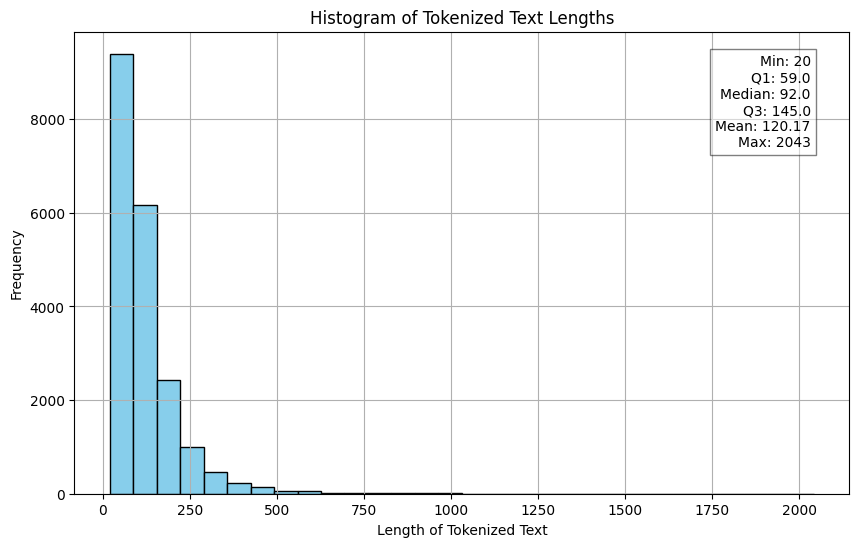

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already created the 'tokenized_dataset'
# Extract the lengths of tokenized_text
tokenized_text_lengths = [len(tokens) for tokens in tokenized_dataset['tokenized_text']]

# Calculate statistics
min_length = np.min(tokenized_text_lengths)
max_length = np.max(tokenized_text_lengths)
q1 = np.percentile(tokenized_text_lengths, 25)
median = np.percentile(tokenized_text_lengths, 50)
q3 = np.percentile(tokenized_text_lengths, 75)
mean_length = np.mean(tokenized_text_lengths)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(tokenized_text_lengths, bins=30, color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Histogram of Tokenized Text Lengths')
plt.xlabel('Length of Tokenized Text')
plt.ylabel('Frequency')

# Add grid for clarity
plt.grid(True)

# Create a dummy plot for legend entries
plt.text(0.95, 0.95, 
         f'Min: {min_length}\nQ1: {q1}\nMedian: {median}\nQ3: {q3}\nMean: {mean_length:.2f}\nMax: {max_length}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right', 
         bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()


In [22]:
max_seq_length = 512

In [23]:
# Filter out sequences longer than max_seq_length
filtered_dataset = tokenized_dataset.filter(lambda example: len(example['tokenized_text']) <= max_seq_length)
filtered_dataset

Filter:   0%|          | 0/20022 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'completion', 'text', 'tokenized_prompt', 'tokenized_completion', 'tokenized_text'],
    num_rows: 19826
})

In [24]:
filtered_dataset = filtered_dataset.remove_columns(["prompt", "completion", "text"])

In [25]:
filtered_dataset

Dataset({
    features: ['tokenized_prompt', 'tokenized_completion', 'tokenized_text'],
    num_rows: 19826
})

In [26]:
def pad_data(examples):
    padded_prompt = tokenizer.pad({'input_ids': examples['tokenized_prompt']}, padding='max_length', max_length=max_seq_length)['input_ids']
    padded_completion = tokenizer.pad({'input_ids': examples['tokenized_completion']}, padding='max_length', max_length=max_seq_length)['input_ids']
    padded_text = tokenizer.pad({'input_ids': examples['tokenized_text']}, padding='max_length', max_length=max_seq_length)['input_ids']
    
    return {
        'tokenized_prompt': padded_prompt,
        'tokenized_completion': padded_completion,
        'tokenized_text': padded_text
    }

In [27]:
padded_dataset = filtered_dataset.map(pad_data, batched=True)
padded_dataset

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Dataset({
    features: ['tokenized_prompt', 'tokenized_completion', 'tokenized_text'],
    num_rows: 19826
})

In [28]:
print(padded_dataset[0]['tokenized_prompt'])

[2, 48134, 15680, 35, 21384, 10, 5043, 14, 1239, 10, 2167, 8135, 8, 9108, 10, 2167, 4195, 634, 143, 30412, 5990, 4, 21062, 12337, 3260, 11, 31886, 4, 50118, 48134, 31652, 35, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [29]:
print(padded_dataset[0]['tokenized_completion'])

[9232, 856, 1640, 1178, 3256, 50118, 1437, 1437, 1437, 49434, 50118, 1437, 1437, 1437, 29072, 10, 2167, 8135, 8, 9108, 10, 2167, 4195, 634, 143, 30412, 5990, 50118, 1437, 1437, 1437, 49434, 50118, 1437, 1437, 1437, 671, 3023, 12606, 176, 2055, 155, 3226, 1178, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [30]:
tokenizer.pad_token_id

1

In [31]:
# Add prompt_mask and completion_mask
def add_masks(example):
    tokenized_text = example['tokenized_text']
    tokenized_prompt = example['tokenized_prompt']
    tokenized_completion = example['tokenized_completion']
    
    # Create a mask of zeros with the same size as tokenized_text
    prompt_mask = torch.zeros_like(torch.tensor(tokenized_text))
    completion_mask = torch.zeros_like(torch.tensor(tokenized_text))
    
    prompt_end_idx = next((i for i, token in enumerate(tokenized_prompt) if token == tokenizer.pad_token_id), len(tokenized_prompt))
    completion_end_idx = next((i for i, token in enumerate(tokenized_completion) if token == tokenizer.pad_token_id), len(tokenized_prompt))
    
    for i in range(prompt_end_idx):
        prompt_mask[i] = 1
    for i in range(prompt_end_idx, prompt_end_idx + completion_end_idx):
        completion_mask[i] = 1
    
    return {
        'prompt_mask': prompt_mask,
        'completion_mask': completion_mask
    }


In [32]:
masked_dataset = padded_dataset.map(add_masks)
masked_dataset

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Dataset({
    features: ['tokenized_prompt', 'tokenized_completion', 'tokenized_text', 'prompt_mask', 'completion_mask'],
    num_rows: 19826
})

In [33]:
# tokenized_text => input_ids
# tokenized_text => labels
# prompt_mask => prompt_mask
# completion_mask => completion_mask
# attention_mask => all ones with same shape as input_ids
def map_features(example):
    # Map 'tokenized_text' to 'input_ids' and 'labels'
    input_ids = example['tokenized_text']
    labels = example['tokenized_text']
    prompt_mask = example['prompt_mask']
    completion_mask = example['completion_mask']
    
    # Create attention mask (all ones, same shape as input_ids)
    attention_mask = [1] * len(input_ids)
    
    # Return the updated dictionary
    return {
        'input_ids': input_ids,
        'labels': labels,
        'attention_mask': attention_mask,
        'prompt_mask': example['prompt_mask'],
        'completion_mask': example['completion_mask']
    }

In [34]:
new_dataset = masked_dataset.map(map_features)
new_dataset = new_dataset.remove_columns(['tokenized_prompt', 'tokenized_completion', 'tokenized_text'])
new_dataset

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt_mask', 'completion_mask', 'input_ids', 'labels', 'attention_mask'],
    num_rows: 19826
})

In [35]:
print(new_dataset[0]['prompt_mask'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [36]:
print(new_dataset[0]['completion_mask'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [37]:
# Test
t1 = torch.tensor(new_dataset[0]['prompt_mask'])
t2 = torch.tensor(new_dataset[0]['completion_mask'])

t1 + t2

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Implement Trainer class

In [38]:
import torch
from transformers import TrainingArguments

In [39]:
class PLWTrainer(SFTTrainer):
    def __init__(self, *args, plw=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.plw = plw

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        logits = outputs.get("logits")
        labels = inputs.pop("labels")
        
        prompt_mask = inputs.get("prompt_mask")
        completion_mask = inputs.get("completion_mask")
        
        weights = self.plw * prompt_mask + completion_mask  
        
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()

        shift_labels = shift_labels.to(shift_logits.device)
        shift_weights = shift_weights.to(shift_logits.device)

        # per-token losses
        loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
        token_losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), 
                                shift_labels.view(-1))

        # Compute weighted average of losses
        loss = (token_losses.float() @ shift_weights.view(-1).float()) / shift_weights.sum()
        return (loss, outputs) if return_outputs else loss

In [40]:
# preprocess_logits_for_metrics
# This function will pass token predictions and token losses to the custom metrics that will be defined later
def preprocess_logits_for_metrics(logits, labels):
    token_preds = logits.argmax(-1)[..., :-1]

    # compute per-token losses
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    token_losses = loss_fct(shift_logits.transpose(1, 2), shift_labels)

    # pass predictions and losses to compute_metrics()
    predictions = (token_preds, token_losses)
    return predictions

In [41]:
def define_compute_metrics(eval_dataset):
    
    prompt_mask = torch.tensor(eval_dataset['prompt_mask'], dtype=torch.float16)
    completion_mask = torch.tensor(eval_dataset['completion_mask'], dtype=torch.float16)
    
    def compute_metrics(data):
        token_predictions, token_losses = data.predictions
        
        token_losses = torch.tensor(token_losses, dtype=torch.float16)
        
        # Shift labels and masks
        labels = data.label_ids[..., 1:]
        shift_prompt_mask = prompt_mask[..., 1:]
        shift_comp_mask = completion_mask[..., 1:]

        
         # average both losses (prompt and completion) over their respective tokens
        prompt_loss = token_losses.reshape(-1) @ shift_prompt_mask.reshape(-1) / shift_prompt_mask.sum()
        completion_loss = token_losses.reshape(-1) @ shift_comp_mask.reshape(-1) / shift_comp_mask.sum()

        # compute response token accuracy
#         nz = np.nonzero(shift_comp_mask)
#         idx = np.where(np.isin(labels[nz], ABCD_token_ids))
#         accuracy = np.mean(token_preds[nz][idx] == labels[nz][idx])

        return {
            'comp_loss': completion_loss,
            'prompt_loss': prompt_loss,
#             'acc': accuracy,
        }
    
    return compute_metrics

In [42]:
final_ds = new_dataset.train_test_split(test_size=0.1)
final_ds

DatasetDict({
    train: Dataset({
        features: ['prompt_mask', 'completion_mask', 'input_ids', 'labels', 'attention_mask'],
        num_rows: 17843
    })
    test: Dataset({
        features: ['prompt_mask', 'completion_mask', 'input_ids', 'labels', 'attention_mask'],
        num_rows: 1983
    })
})

In [43]:
trainer5 = PLWTrainer(
    model,
    train_dataset=final_ds['train'],
    eval_dataset=final_ds['test'],
    plw=0.7,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        remove_unused_columns=False,
        eval_strategy="steps",
        eval_steps=10,
        output_dir="output",
    ),
    compute_metrics=define_compute_metrics(final_ds['test']),
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [44]:
masked = trainer5.data_collator.torch_call([trainer5.train_dataset[0]])
masked = masked.to(model.device)

In [45]:
masked

{'prompt_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 

In [46]:
loss, outputs = trainer5.compute_loss(model, masked, return_outputs=True)
loss

tensor(3.0782, device='cuda:0', grad_fn=<DivBackward0>)

In [47]:
trainer5.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Comp Loss,Prompt Loss,Runtime,Samples Per Second,Steps Per Second
10,No log,2.531247,nan,nan,284.848700,6.962000,6.962000


KeyboardInterrupt: 